In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
import os

# Replace this with the actual path to your shared folder
folder_path = "/content/drive/MyDrive/LLMs in Hebrew & Arabic - Project/eval/eval"

In [15]:
import pandas as pd
import os
import glob

# Path to your CSV files
path = folder_path
csv_files = glob.glob(os.path.join(path, "*.csv"))

# Storage for all data
all_data = []

# Process each CSV file
for file in csv_files:
    # Parse filename: [model]_[languageQ]_[iter]_evaluated_[languageE].csv
    base = os.path.basename(file).replace(".csv", "")
    model, languageQ, iter_num, _, languageE = base.split("_")

    df = pd.read_csv(file)

    # Add metadata columns
    df["model"] = model
    df["languageQ"] = languageQ
    df["iter"] = int(iter_num)
    df["languageE"] = languageE

    all_data.append(df)

# Combine all into one DataFrame
df_all = pd.concat(all_data, ignore_index=True)

# Scores to analyze
score_cols = ["Accuracy", "Completeness", "Clarity", "Final Score"]

# Function to aggregate: mean and std
def get_aggregates(df, groupby_cols):
    means = df.groupby(groupby_cols)[score_cols].mean().reset_index()
    stds = df.groupby(groupby_cols)[score_cols].std().reset_index()

    # Rename std columns
    stds = stds.rename(columns={col: col + "_std" for col in score_cols})

    # Merge mean and std on groupby columns
    return pd.merge(means, stds, on=groupby_cols)

# All grouping combinations
groupings = [
    ["model"],
    ["languageQ"],
    ["languageE"],
    ["model", "languageQ"],
    ["model", "languageE"],
    ["languageQ", "languageE"],
    ["model", "languageQ", "languageE"],
]

# Compute and print summaries
results = {}
for grouping in groupings:
    key = "_".join(grouping)
    print(key)
    results[key] = get_aggregates(df_all, grouping)
    print(results[key])
    print()
    print()

# # To save all summaries to CSV (optional)
# for key, summary_df in results.items():
#     summary_df.to_csv(f"{key}_summary.csv", index=False)

summary_df = results[key]


model
      model   Accuracy  Completeness    Clarity  Final Score  Accuracy_std  \
0    gemma3  94.056856     86.897822  94.505017    92.463899      5.830387   
1      phi4  51.956667     57.258333  63.201667    57.271812     35.480552   
2  phi4mini  38.958333     38.866667  53.191667    43.505863     35.994666   
3     qwen3  80.096667     79.478333  78.075125    79.547138     21.641270   

   Completeness_std  Clarity_std  Final Score_std  
0          8.694939     4.024108         5.495317  
1         29.667466    27.950905        30.218976  
2         32.502198    33.865169        32.996116  
3         16.213091    22.101152        19.214384  


languageQ
  languageQ   Accuracy  Completeness    Clarity  Final Score  Accuracy_std  \
0    arabic  66.741667     65.708333  76.458333    69.645943     32.857038   
1   english  95.210417     90.129167  95.937500    94.555809      6.463604   
2    hebrew  51.231733     53.184953  56.078370    53.493179     36.908406   

   Completeness_st

In [16]:
summary_df.to_csv(f"summary.csv", index=False)

In [20]:
df_all.isna().sum()

,0
text,0
classify,0
eval,0
Accuracy,0
Completeness,1
Clarity,1
Final Score,0
Explanation,3
model,0
languageQ,0


In [18]:
mask = df_all["Final Score"].isna()

df_all.loc[mask, "Final Score"] = (
    df_all.loc[mask, "Accuracy"] * 0.4 +
    df_all.loc[mask, "Completeness"] * 0.3 +
    df_all.loc[mask, "Clarity"] * 0.3
)

In [21]:
from scipy.stats import f_oneway

# Unique question languages
languagesQ = df_all["languageQ"].unique()

# Store results
anova_results = {}

for lang in languagesQ:
    df_lang = df_all[df_all["languageQ"] == lang]

    # Group Final Scores by model
    model_groups = [group["Final Score"].values for _, group in df_lang.groupby("model")]
    # print(model_groups)

    # Skip if not enough data
    if len(model_groups) > 1:
        stat, pval = f_oneway(*model_groups)
        anova_results[lang] = {"F-statistic": stat, "p-value": pval}
    else:
        anova_results[lang] = {"F-statistic": None, "p-value": None}

# Display results
for lang, res in anova_results.items():
    print(f"LanguageQ = {lang}: F = {res['F-statistic']}, p = {res['p-value']}")


LanguageQ = arabic: F = 406.6848764109385, p = 3.3107774198329856e-170
LanguageQ = hebrew: F = 624.9251678525474, p = 1.364772952759759e-224
LanguageQ = english: F = 23.07822317919011, p = 5.794351008231879e-14


In [22]:
from scipy.stats import f_oneway

# Unique question languages
languagesQ = df_all["languageQ"].unique()
models = df_all["model"].unique()

anova_fixedE = {}
anova_matchedE = {}

# --- Test 1: Evaluation Language = "english" ---
for lang in languagesQ:
    df_lang = df_all[(df_all["languageQ"] == lang) & (df_all["languageE"] == "english")]

    model_groups = [group["Final Score"].dropna().values
                    for _, group in df_lang.groupby("model") if not group["Final Score"].dropna().empty]

    if len(model_groups) > 1:
        stat, pval = f_oneway(*model_groups)
        anova_fixedE[lang] = {"F-statistic": stat, "p-value": pval}
    else:
        anova_fixedE[lang] = {"F-statistic": None, "p-value": None}


# --- Test 2: Evaluation Language == Question Language ---
for lang in languagesQ:
    df_lang = df_all[(df_all["languageQ"] == lang) & (df_all["languageE"] == lang)]

    model_groups = [group["Final Score"].dropna().values
                    for _, group in df_lang.groupby("model") if not group["Final Score"].dropna().empty]

    if len(model_groups) > 1:
        stat, pval = f_oneway(*model_groups)
        anova_matchedE[lang] = {"F-statistic": stat, "p-value": pval}
    else:
        anova_matchedE[lang] = {"F-statistic": None, "p-value": None}


# --- Display Results ---
print("=== ANOVA: languageE = 'english' ===")
for lang, res in anova_fixedE.items():
    print(f"{lang}: F = {res['F-statistic']}, p = {res['p-value']}")

print("\n=== ANOVA: languageE == languageQ ===")
for lang, res in anova_matchedE.items():
    print(f"{lang}: F = {res['F-statistic']}, p = {res['p-value']}")

=== ANOVA: languageE = 'english' ===
arabic: F = 201.26022712779022, p = 2.83469490199886e-84
hebrew: F = 318.3821515539231, p = 2.9216533855105515e-113
english: F = 23.07822317919011, p = 5.794351008231879e-14

=== ANOVA: languageE == languageQ ===
arabic: F = 205.554479697653, p = 1.6927630263520175e-85
hebrew: F = 308.07752532598994, p = 5.21511316854647e-111
english: F = 23.07822317919011, p = 5.794351008231879e-14


In [23]:
from scipy.stats import ttest_rel
import pandas as pd

# Define the language pairs
language_pairs = [("english", "hebrew"), ("english", "arabic"), ("hebrew", "arabic")]
models = df_all["model"].unique()

# Storage
ttest_fixedE = {}
ttest_matchedE = {}

# --- Test 1: Evaluation Language fixed as English ---
for model in models:
    df_model = df_all[(df_all["model"] == model) & (df_all["languageE"] == "english")]

    for lang1, lang2 in language_pairs:
        df1 = df_model[df_model["languageQ"] == lang1][["Final Score"]].reset_index(drop=True)
        df2 = df_model[df_model["languageQ"] == lang2][["Final Score"]].reset_index(drop=True)

        min_len = min(len(df1), len(df2))
        if min_len < 2:
            ttest_fixedE[(model, lang1, lang2)] = {"t-statistic": None, "p-value": None}
            continue

        df1 = df1.iloc[:min_len].rename(columns={"Final Score": f"score_{lang1}"})
        df2 = df2.iloc[:min_len].rename(columns={"Final Score": f"score_{lang2}"})
        merged = pd.concat([df1, df2], axis=1)

        stat, pval = ttest_rel(merged[f"score_{lang1}"], merged[f"score_{lang2}"])
        ttest_fixedE[(model, lang1, lang2)] = {"t-statistic": stat, "p-value": pval}


# --- Test 2: Evaluation Language == Question Language ---
for model in models:
    df_model = df_all[(df_all["model"] == model) & (df_all["languageE"] == df_all["languageQ"])]

    for lang1, lang2 in language_pairs:
        df1 = df_model[df_model["languageQ"] == lang1][["Final Score"]].reset_index(drop=True)
        df2 = df_model[df_model["languageQ"] == lang2][["Final Score"]].reset_index(drop=True)

        min_len = min(len(df1), len(df2))
        if min_len < 2:
            ttest_matchedE[(model, lang1, lang2)] = {"t-statistic": None, "p-value": None}
            continue

        df1 = df1.iloc[:min_len].rename(columns={"Final Score": f"score_{lang1}"})
        df2 = df2.iloc[:min_len].rename(columns={"Final Score": f"score_{lang2}"})
        merged = pd.concat([df1, df2], axis=1)

        stat, pval = ttest_rel(merged[f"score_{lang1}"], merged[f"score_{lang2}"])
        ttest_matchedE[(model, lang1, lang2)] = {"t-statistic": stat, "p-value": pval}


# --- Print Results ---
print("=== T-TEST: languageE = 'english' ===")
for (model, l1, l2), res in ttest_fixedE.items():
    print(f"{model}: {l1} vs {l2} — t = {res['t-statistic']}, p = {res['p-value']}")

print("\n=== T-TEST: languageE == languageQ ===")
for (model, l1, l2), res in ttest_matchedE.items():
    print(f"{model}: {l1} vs {l2} — t = {res['t-statistic']}, p = {res['p-value']}")


=== T-TEST: languageE = 'english' ===
gemma3: english vs hebrew — t = 5.887799278607245, p = 3.76398613421441e-08
gemma3: english vs arabic — t = 5.303883525323384, p = 5.309669792113839e-07
gemma3: hebrew vs arabic — t = -1.399177800174907, p = 0.1643828353849308
qwen3: english vs hebrew — t = 16.758156815628507, p = 4.183539972204543e-33
qwen3: english vs arabic — t = 8.24195982634565, p = 2.553533366638966e-13
qwen3: hebrew vs arabic — t = -13.855089446900795, p = 1.3951970463145512e-26
phi4: english vs hebrew — t = 27.32964057788664, p = 4.0759044901090844e-53
phi4: english vs arabic — t = 16.47122195030004, p = 1.767754007779668e-32
phi4: hebrew vs arabic — t = -9.589258707521202, p = 1.757602324351463e-16
phi4mini: english vs hebrew — t = 35.91510679734331, p = 1.0443680639324434e-65
phi4mini: english vs arabic — t = 20.113036312570266, p = 4.325251195633088e-40
phi4mini: hebrew vs arabic — t = -9.228707197974995, p = 1.2556668868656011e-15

=== T-TEST: languageE == languageQ ===

In [24]:
from scipy.stats import ttest_rel
import pandas as pd

# Initialize results dictionary
ttest_eval_method_comparison = {}

# Loop over models
for model in df_all["model"].unique():
    # Filter rows where languageQ == 'hebrew'
    df_hebrewQ = df_all[df_all["languageQ"] == "hebrew"]

    # Extract scores for both evaluation methods
    df_engE = df_hebrewQ[(df_hebrewQ["languageE"] == "english") & (df_hebrewQ["model"] == model)][["Final Score"]].reset_index(drop=True)
    df_hebE = df_hebrewQ[(df_hebrewQ["languageE"] == "hebrew") & (df_hebrewQ["model"] == model)][["Final Score"]].reset_index(drop=True)

    # Align lengths
    min_len = min(len(df_engE), len(df_hebE))
    if min_len < 2:
        ttest_eval_method_comparison[model] = {"t-statistic": None, "p-value": None}
        continue

    scores_english = df_engE.iloc[:min_len]["Final Score"]
    scores_hebrew  = df_hebE.iloc[:min_len]["Final Score"]

    # Perform paired t-test
    stat, pval = ttest_rel(scores_english, scores_hebrew)
    ttest_eval_method_comparison[model] = {"t-statistic": stat, "p-value": pval}

# Print the results
print("=== T-TEST: Evaluation method comparison for languageQ = 'hebrew' ===")
for model, res in ttest_eval_method_comparison.items():
    print(f"{model}: englishE vs hebrewE — t = {res['t-statistic']}, p = {res['p-value']}")


=== T-TEST: Evaluation method comparison for languageQ = 'hebrew' ===
gemma3: englishE vs hebrewE — t = 1.3527141229814337, p = 0.17873331970056433
qwen3: englishE vs hebrewE — t = -2.300743179988918, p = 0.023147127252576075
phi4: englishE vs hebrewE — t = -0.8634837330407772, p = 0.38960859037755124
phi4mini: englishE vs hebrewE — t = -2.5107914639060716, p = 0.013387864882449403


In [25]:
from scipy.stats import ttest_rel
import pandas as pd

# Initialize results dictionary
ttest_eval_method_arabicQ = {}

# Loop over models
for model in df_all["model"].unique():
    # Filter for questions in Arabic
    df_arabicQ = df_all[df_all["languageQ"] == "arabic"]

    # Extract scores for both evaluation settings
    df_engE = df_arabicQ[(df_arabicQ["languageE"] == "english") & (df_arabicQ["model"] == model)][["Final Score"]].reset_index(drop=True)
    df_arbE = df_arabicQ[(df_arabicQ["languageE"] == "arabic") & (df_arabicQ["model"] == model)][["Final Score"]].reset_index(drop=True)

    # Ensure equal length
    min_len = min(len(df_engE), len(df_arbE))
    if min_len < 2:
        ttest_eval_method_arabicQ[model] = {"t-statistic": None, "p-value": None}
        continue

    scores_english = df_engE.iloc[:min_len]["Final Score"]
    scores_arabic  = df_arbE.iloc[:min_len]["Final Score"]

    # Paired t-test
    stat, pval = ttest_rel(scores_english, scores_arabic)
    ttest_eval_method_arabicQ[model] = {"t-statistic": stat, "p-value": pval}

# Print the results
print("=== T-TEST: Evaluation method comparison for languageQ = 'arabic' ===")
for model, res in ttest_eval_method_arabicQ.items():
    print(f"{model}: englishE vs arabicE — t = {res['t-statistic']}, p = {res['p-value']}")


=== T-TEST: Evaluation method comparison for languageQ = 'arabic' ===
gemma3: englishE vs arabicE — t = 5.977898851337386, p = 2.4251795869841674e-08
qwen3: englishE vs arabicE — t = 3.641905348841526, p = 0.0004020239127566383
phi4: englishE vs arabicE — t = 1.0807660835965072, p = 0.2819866176291356
phi4mini: englishE vs arabicE — t = -0.13284551625063812, p = 0.8945399337262376


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

<ipython-input-47-c440aa68fbb3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_df_english["model"] = summary_df_english["model"].str.title()
<ipython-input-47-c440aa68fbb3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_df_english["languageQ"] = summary_df_english["languageQ"].str.capitalize()
<ipython-input-47-c440aa68fbb3>:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


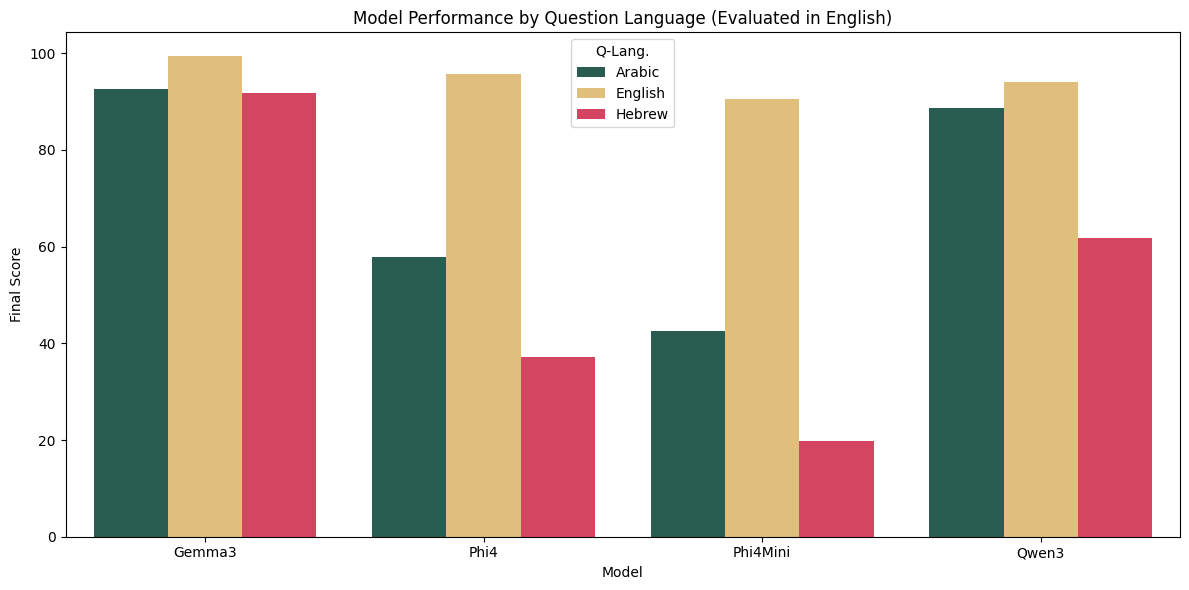

In [47]:
# Filter for English evaluation language only
summary_df_english = summary_df[summary_df["languageE"] == "English"]

# Capitalize model and language names
summary_df_english["model"] = summary_df_english["model"].str.title()
summary_df_english["languageQ"] = summary_df_english["languageQ"].str.capitalize()

# Define custom color palette for question languages
custom_palette = {
    "English": "#f1c46a",
    "Hebrew": "#eb2d53",
    "Arabic": "#226556"
}

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=summary_df_english,
    x="model", y="Final Score",
    hue="languageQ",
    errorbar="sd",
    ci=None,
    palette=custom_palette
)
plt.title("Model Performance by Question Language (Evaluated in English)")
plt.ylabel("Final Score")
plt.xlabel("Model")
plt.legend(title="Q-Lang.")
plt.tight_layout()
plt.show()

<ipython-input-44-e5f96a40f975>:31: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.catplot(


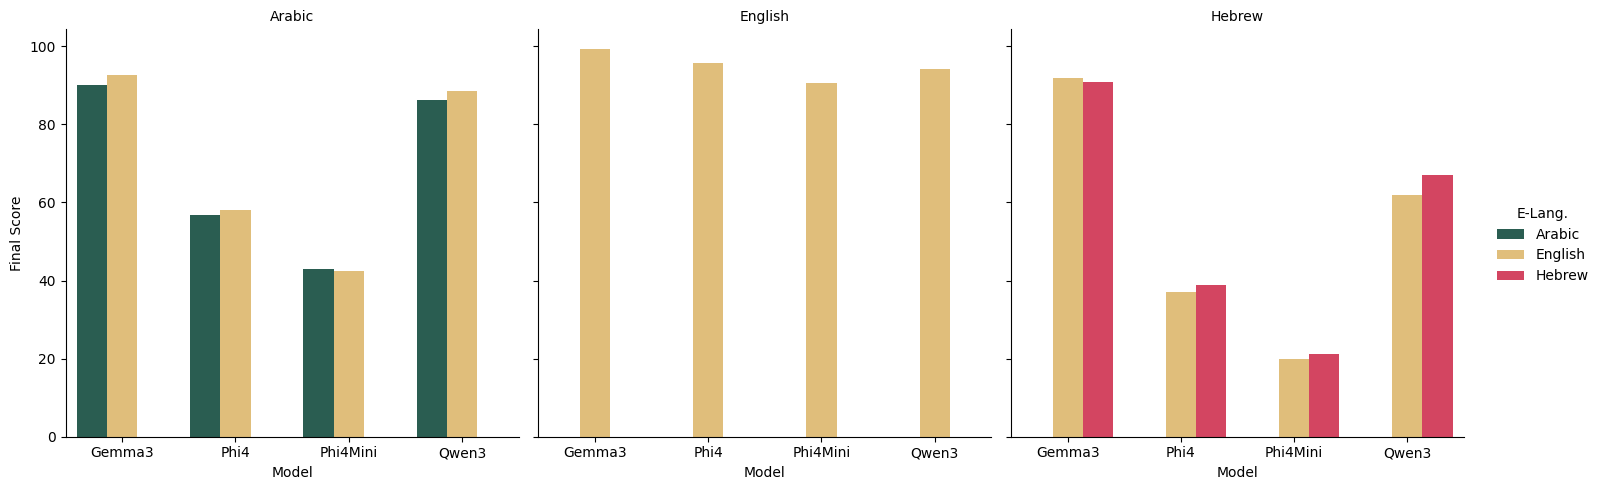

In [44]:
# Capitalize relevant columns
summary_df["model"] = summary_df["model"].str.title()
summary_df["languageE"] = summary_df["languageE"].str.capitalize()
summary_df["languageQ"] = summary_df["languageQ"].str.capitalize()

# Define custom color palette
custom_palette = {
    "English": "#f1c46a",
    "Hebrew": "#eb2d53",
    "Arabic": "#226556"
}

# Plot
g = sns.catplot(
    data=summary_df,
    kind="bar",
    x="model", y="Final Score",
    hue="languageE",
    col="languageQ",
    ci=None,
    palette=custom_palette,
    height=5, aspect=1
)
g.set_titles("{col_name}")
g.set_axis_labels("Model", "Final Score")
g._legend.set_title("E-Lang.")
g.tight_layout()
plt.show()


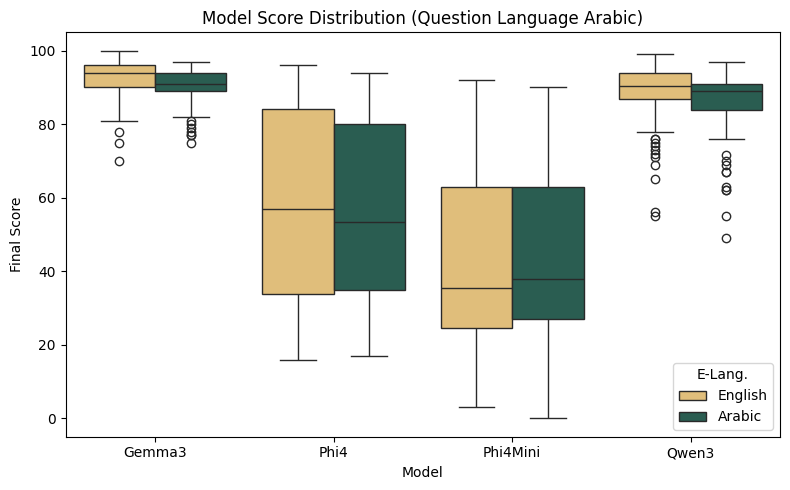

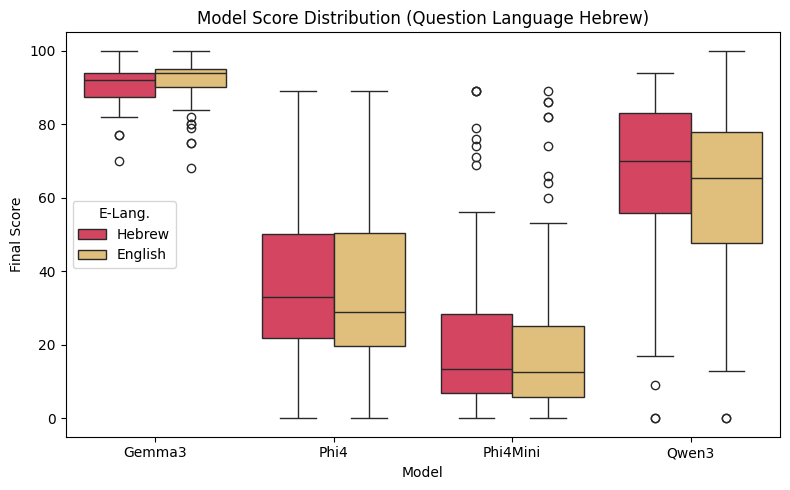

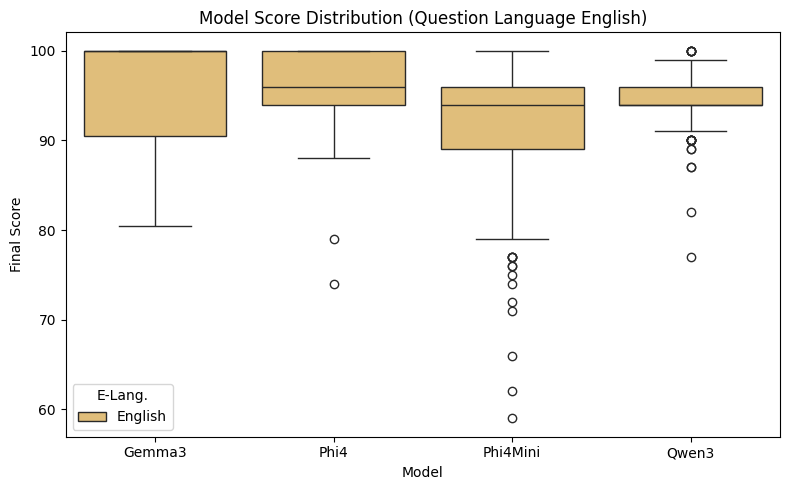

In [42]:
# Capitalize relevant columns
df_all["model"] = df_all["model"].str.title()
df_all["languageE"] = df_all["languageE"].str.capitalize()
df_all["languageQ"] = df_all["languageQ"].str.capitalize()

# Define color palette and fixed model order
custom_palette = {
    "English": "#f1c46a",
    "Hebrew": "#eb2d53",
    "Arabic": "#226556"
}

# Define the fixed order for models
model_order = ["Gemma3", "Phi4", "Phi4Mini", "Qwen3"]

# Plot for each language
for lang in df_all["languageQ"].unique():
    plt.figure(figsize=(8, 5))
    sns.boxplot(
        data=df_all[df_all["languageQ"] == lang],
        x="model", y="Final Score",
        hue="languageE",
        palette=custom_palette,
        order=model_order
    )
    plt.title(f"Model Score Distribution (Question Language {lang})")
    plt.ylabel("Final Score")
    plt.xlabel("Model")
    plt.legend(title="E-Lang.")
    plt.tight_layout()
    plt.show()